In [87]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

In [88]:
# Función para inicializar el grid con celdas infectadas aleatoriamente
def initialize_grid(M, N, I0):
    grid = np.zeros((M, N), dtype=int)  # Todas las celdas son susceptibles inicialmente (0)
    
    # Elegir I0 celdas aleatorias para ser infectadas
    infected_cells = random.sample([(i, j) for i in range(M) for j in range(N)], I0)
    for cell in infected_cells:
        grid[cell] = 1  # Infectadas (estado 1)
    
    return grid

In [89]:
# Función para obtener la vecindad de una celda (i, j) con radio rad
def get_neighborhood(grid, i, j, rad):
    M, N = grid.shape
    neighborhood = grid[max(0, i-rad):min(M, i+rad+1), max(0, j-rad):min(N, j+rad+1)]
    return neighborhood

In [90]:
# Función para ejecutar la simulación
def simulate_sir(M, N, T, I0, rad, beta, gamma):
    grid = initialize_grid(M, N, I0)
    grid_history = []  # Historial del grid
    population_counts = []  # Historial de S, I, R
    
    for t in range(T):
        new_grid = grid.copy()
        S_count = 0
        I_count = 0
        R_count = 0
        
        for i in range(M):
            for j in range(N):
                if grid[i, j] == 0:  # Susceptible
                    neighborhood = get_neighborhood(grid, i, j, rad)
                    infected_neighbors = np.sum(neighborhood == 1)
                    total_neighbors = neighborhood.size
                    
                    # Probabilidad de infección
                    if infected_neighbors > 0:
                        infection_probability = beta * (infected_neighbors / total_neighbors)
                        if random.random() < infection_probability:
                            new_grid[i, j] = 1  # Infectar la celda
                
                elif grid[i, j] == 1:  # Infectado
                    # Probabilidad de recuperación
                    if random.random() < gamma:
                        new_grid[i, j] = 2  # Recuperar la celda
        
        # Actualizar el grid y registrar las cantidades de S, I, R
        grid = new_grid
        S_count = np.sum(grid == 0)
        I_count = np.sum(grid == 1)
        R_count = np.sum(grid == 2)
        
        grid_history.append(grid.copy())
        population_counts.append((S_count, I_count, R_count))
    
    return grid_history, population_counts

In [91]:
# Función para graficar el promedio de S, I, R
def nexp_plot(S_avg, I_avg, R_avg, T, beta, gamma):
    t = np.arange(T)
    plt.figure(figsize=(10, 6))
    plt.plot(t, S_avg, label="S(t) - Susceptibles", color='blue')
    plt.plot(t, I_avg, label="I(t) - Infectados",color='green')
    plt.plot(t, R_avg, label="R(t) - Recuperados",color='red')
    plt.title(f"Resultados para β={beta}, γ={gamma}")
    plt.xlabel("Tiempo")
    plt.ylabel("Población")
    plt.legend()

In [92]:
# Graficar la evolución de S, I, R
def animate_grid(grid_history):
  colors = ['purple', 'yellow', 'green']  # Morado: Susceptible, Amarillo: Infectado, Verde: Recuperado
  cmap = ListedColormap(colors)
  
  fig, ax = plt.subplots()
  img = ax.imshow(grid_history[0], cmap=cmap, vmin=0, vmax=2)

  def update(frame):
      img.set_data(grid_history[frame])
      ax.set_title(f'Día {frame}')
      return [img]

  ani = animation.FuncAnimation(fig, update, frames=len(grid_history), blit=False)
  return ani

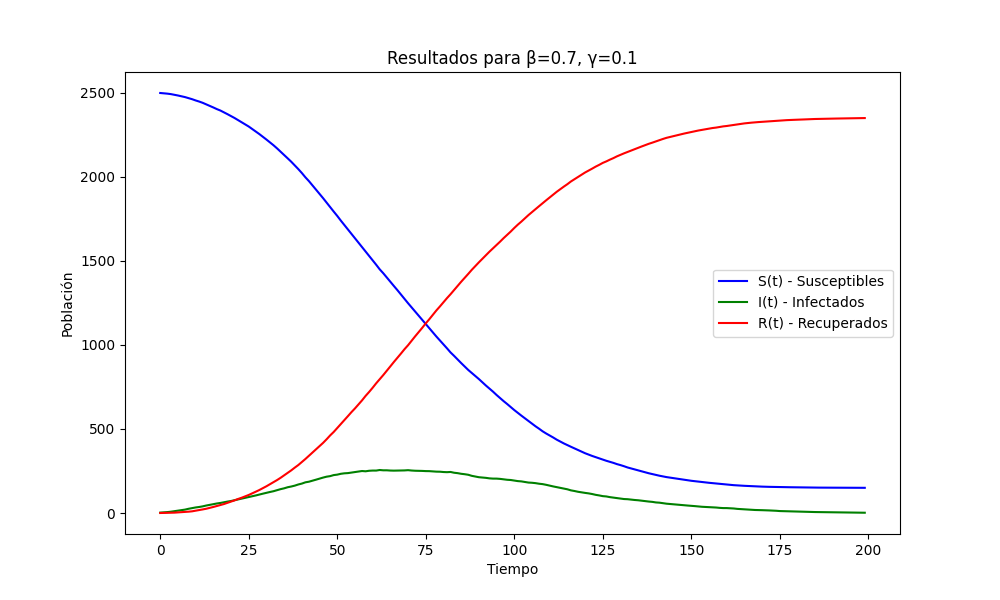

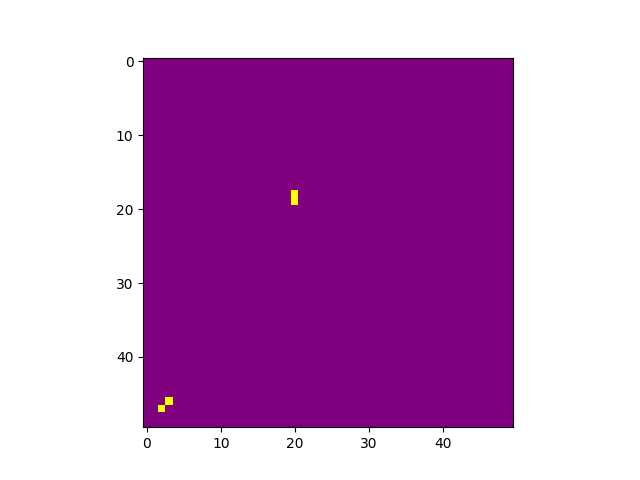

In [93]:
# Parámetros del modelo
M = 50  # Tamaño del grid en filas
N = 50  # Tamaño del grid en columnas
T = 200  # Tiempo de simulación
I0 = 2  # Número inicial de infectados
rad = 1  # Radio de interacción
beta = 0.2  # Probabilidad de infección
gamma = 0.75  # Probabilidad de recuperación
N_exp = 20  # Número de repeticiones de la simulación

total_S = np.zeros((T,))
total_I = np.zeros((T,))
total_R = np.zeros((T,))

for i in range(N_exp):
    grid_history, population_counts = simulate_sir(M, N, T, I0, rad, beta, gamma)
    total_S += np.array([x[0] for x in population_counts])
    total_I += np.array([x[1] for x in population_counts])
    total_R += np.array([x[2] for x in population_counts])

# Graficar la última evolución de S, I y R calculada.
ani = animate_grid(grid_history)
avg_S = total_S / N_exp
avg_I = total_I / N_exp
avg_R = total_R / N_exp

nexp_plot(avg_S, avg_I, avg_R, T, beta, gamma)
plt.show()